In [ ]:
# This notebook adapted from original version by L.Stuart

# Evaluate classification models & dump images for diagnosis/labelling

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import sys
from catboost import CatBoostClassifier, Pool
from scipy.ndimage import binary_dilation
from sklearn import clone
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from metaspace.sm_annotation_utils import SMInstance
from metaspace.image_processing import clip_hotspots
import getpass
from metaspace import SMInstance
from datetime import datetime
from matplotlib.colors import Normalize, LogNorm

In [3]:
# Suppress warnings, because many models spam them during feature selection
# as some subsets of features just don't have enough information to make
# a good model.
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

## Utility functions

In [4]:
def colorize_image_with_mask(image, mask):
    """Plotting function for combining a colorized ion image with a spot mask"""
    
    image = clip_hotspots(image)
    image /= np.max(image)
    
    on_spot_colorized = plt.cm.cividis(image)
    off_spot_colorized = plt.cm.magma(image)
    return np.where(mask[:,:,np.newaxis], on_spot_colorized, off_spot_colorized)

def make_a_panel(image, tic_image, mask):
    
    x = image.shape[1]
    y = image.shape[0]

    norm = Normalize() # This is a matplotlib tool to scale everything to the 0-1 range
    log_norm = LogNorm() # Same, but it does a log transform before scaling to the 0-1 range
    new_shape = (y, x*4 + 3, 4)  # The "4" is to fit that per-pixel RGBA dimension
    
    panel = np.zeros(shape=new_shape)
    panel[0:y, 0:x] = colorize_image_with_mask(image, mask)
    panel[0:y, x+1:2*x+1] = plt.cm.cividis(norm(clip_hotspots(image)))
    panel[0:y, 2*x+2:3*x+2] = plt.cm.cividis(log_norm(image + 1))
    panel[0:y, -x:] = plt.cm.cividis(Normalize()(clip_hotspots(tic_image)))    
    return panel    
    
    
def save_image_with_mask(image, mask, fname, tic_image):
    plt.imsave(fname, make_a_panel(image, tic_image, mask))

In [5]:
def crop_zeros(img):
    """Crop an image, removing all empty outer rows/columns"""
    cols = np.flatnonzero(np.count_nonzero(img, axis=0) != 0)
    rows = np.flatnonzero(np.count_nonzero(img, axis=1) != 0)
    top = rows[0]
    bottom = rows[-1] + 1
    left = cols[0]
    right = cols[-1] + 1

    return img[top:bottom, left:right]

In [6]:
def get_mispredictions(model, X, y):
    """
    Find which values would be mispredicted, returning two lists:
        * indexes of items that would be falsely predicted as positives
        * indexes of items that would be falsely predicted as negatives
        
    cross_val_predict uses a shuffled 5-fold test-train split so that each chunk of 
    20% of the input data gets its own model that was trained on the other 80%, 
    ensuring that the items being predicted aren't included in the training data.
    """
    preds = cross_val_predict(model, X, y)
    mispreds = preds != y
    fpos_idxs = np.flatnonzero(mispreds & ~y)
    fneg_idxs = np.flatnonzero(mispreds & y)
        
    return fpos_idxs, fneg_idxs

## Paths

In [7]:
p_root_dir = Path.cwd().parents[0]
p_analysis = p_root_dir  / "3_train_classifier"
p_grids = p_analysis / r"data_for_model_training\labelled_set_masks\grid_masks"
p_labelled_set = p_analysis / r"data_for_model_training\labelled_set"
p_wellmap = p_root_dir / "5_data/metadata/wellmap.csv"

# Paths for evaluation
p_eval = p_analysis / "model_evaluation"
p_metrics = p_eval / "metrics.csv"
p_images = p_eval / "images.hdf5"
p_model = p_eval / "model.json"

timestamp = datetime.now().strftime("%d-%b-%Y") 
p_predictions = p_eval / f"labelles_set_predictions_{timestamp}.csv"

# False positives/negatives - preview output from model prediction for molecules with known labels
# Note that all files in these directories are cleared before a prediction run
p_eval_fpos = p_eval / 'false_positives'
p_eval_fneg = p_eval / 'false_negatives'
p_eval_tpos = p_eval / 'true_positives'
p_eval_tneg = p_eval / 'true_negatives'
# Unknown positives/negatives - preview output from model prediction for molecules with no label
# Note that all files in these directories are cleared before a prediction run
p_eval_upos = p_eval / 'unknown_positives'
p_eval_uneg = p_eval / 'unknown_negatives'
# Manually labeled positives/negatives - Move preview files from any of the above directories into 
# these directories to add to the labelled data. Make sure to re-run the appropriate steps 
# in "Input data" to detect the changes
p_eval_lpos = p_eval / 'manual_label_positives'
p_eval_lneg = p_eval / 'manual_label_negatives'

# Directories for three-state positive/unsure/negative classification
p_tri_pos = p_eval / 'three-state' / 'positive'
p_tri_unk = p_eval / 'three-state' / 'unsure'
p_tri_neg = p_eval / 'three-state' / 'negative'

# METASPACE
database = ('Spotting_project_compounds-v9', 'feb2021')
fdr = 0.5

## Input data

In [8]:
# Get dataset IDs based on Quality_Labels.csv files 
dataset_ids = pd.concat([
    pd.read_csv(f)
    for f in p_labelled_set.rglob("*Quality_Labels.csv")
]).dataset_id.unique().tolist()

## Download images from metaspace or load them in if they were pre-saved

In [11]:
# Log into metaspace
sm = SMInstance(host='https://metaspace2020.eu')

if not sm.logged_in():
    # Using getpass here prevents the API key from being accidentally saved with this notebook.
    api_key = getpass.getpass(prompt='API key: ', stream=None)
    sm.login(api_key=api_key)

API key: ········


In [14]:
# Download images from METASPACE
# Ignore any warnings about connection pools in this step

images = []
for i, ds_id in enumerate(dataset_ids):
    print(f'Downloading images for {ds_id} ({i}/{len(dataset_ids)})')
    dataset = sm.dataset(id=ds_id)
    ds_tic_image = dataset.tic_image()
    for img in dataset.all_annotation_images(
        fdr=fdr, 
        database=database, 
        only_first_isotope=True, 
        scale_intensity=True, 
        hotspot_clipping=False
    ):
        # Exclude annotations with no first-isotopic-image
        if img[0] is not None:
            images.append({
                'dataset_id': ds_id,
                'formula': img.formula,
                'adduct': img.adduct,
                'neutral_loss': img.neutral_loss or '',
                'image': img[0],
                'tic_norm_image': np.nan_to_num(img[0] / ds_tic_image),  # nan_to_num replaces nan values with 0.0. This line will probably complain about division by zero but it can be ignored as it's fixed by the nan_to_num
            })

images_df = pd.DataFrame(images)
p_eval.mkdir(parents=True, exist_ok=True)
images_df.to_hdf(p_images, key="df")

100%|████████████████████████████████████████| 332/332 [00:01<00:00, 233.44it/s]                                       


100%|████████████████████████████████████████| 185/185 [00:00<00:00, 193.19it/s]                                       


100%|████████████████████████████████████████| 336/336 [00:01<00:00, 177.44it/s]                                       


100%|████████████████████████████████████████| 196/196 [00:01<00:00, 158.16it/s]                                       


100%|████████████████████████████████████████| 330/330 [00:01<00:00, 203.40it/s]                                       


100%|████████████████████████████████████████| 191/191 [00:00<00:00, 192.64it/s]                                       


100%|████████████████████████████████████████| 288/288 [00:01<00:00, 187.48it/s]                                       


100%|████████████████████████████████████████| 183/183 [00:00<00:00, 193.72it/s]                                       


100%|████████████████████████████████████████| 194/194 [00:01<00:00, 183.24it/s]                                       


100%|████████████████████████████████████████| 336/336 [00:01<00:00, 188.51it/s]                                       


100%|████████████████████████████████████████| 336/336 [00:01<00:00, 180.40it/s]                                       


100%|████████████████████████████████████████| 188/188 [00:01<00:00, 175.57it/s]                                       


100%|████████████████████████████████████████| 336/336 [00:01<00:00, 171.48it/s]                                       


100%|████████████████████████████████████████| 195/195 [00:00<00:00, 204.94it/s]                                       
C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['dataset_id', 'formula', 'adduct', 'neutral_loss', 'image',
       'tic_norm_image'],
      dtype='object')]

  pytables.to_hdf(


In [9]:
# Or load pre-saved images
images_df = pd.read_hdf(p_eval / "images.hdf5")

In [10]:
# Wellmap and grids
wellmap = pd.read_csv(p_wellmap)
grids = {
    ds_id: np.load(p_grids / f'{ds_id}.npy') 
    for ds_id in dataset_ids
}

In [11]:
# Image labels from Quality_Labels.csv files
labeled_anns = []
for i in p_labelled_set.rglob("*Quality_Labels.csv"):
    data = pd.read_csv(i)
    data = data.loc[:, ['dataset_id', 'formula', 'adduct', 'neutral_loss', 'score', 'well']]
    data.neutral_loss.fillna('', inplace=True)
    labeled_anns.append(data)

labeled_anns_df = pd.concat(labeled_anns)

### Import image labels from the manual_label directories

If you use these directories for labelling, re-run every cell from this point onwards

In [12]:
# Image labels from the "manual_label" directories
manual_labels = []
for score, labels_path in [(1, p_eval_lpos), (0, p_eval_lneg)]:
    labels_path.mkdir(parents=True, exist_ok=True)
    for f in labels_path.glob('*.png'):
        manual_labels.append({
            'filename': f.name,
            'manual_score': score,
        })
if manual_labels:
    manual_labels_df = pd.DataFrame(manual_labels)
else:
    manual_labels_df = pd.DataFrame({'filename': pd.Series(dtype=str), 'manual_score': pd.Series(dtype='i')})

In [13]:
# Combine them for easier access
merged_df = (
    images_df
    # Add `how=left` when merging with wellmap to include non-spotted formulas
    .merge(wellmap[['well', 'formula', 'name_short']], on=['formula'])
    .merge(labeled_anns_df, on=['dataset_id', 'formula', 'adduct', 'neutral_loss', 'well'], how='left')
).reset_index()

merged_df['filename'] = [f'{row.dataset_id}_{row.formula}_{row.adduct}_{row.neutral_loss}_{row.well}.png' for row in merged_df.itertuples()]
merged_df = merged_df.merge(manual_labels_df, on='filename', how='left')

# Merge the "manual_score" column into "score"
merged_df['score'] = merged_df.manual_score.fillna(merged_df.score) # manual labels overwrite csv labels
del merged_df['manual_score']

merged_df['row_id'] = [f'{row.dataset_id}_{row.formula}_{row.adduct}_{row.neutral_loss}_{row.well}' for row in merged_df.itertuples()]  # You may want to customize this and add any other fields you feel are necessary to uniquely identify a scored image+well
merged_df = merged_df.set_index('row_id')

## Calculate metrics (or load pre-calculated)

In [23]:
#Calculate metrics
def calc_far_bg(mask, bg):
    """Gets mask for background pixels that are at least 4 radii away from the spot"""
    # 3 iterations = (1+3=)4x the spot radius
    expanded_spot = binary_dilation(mask, crop_zeros(mask), iterations=3)
    return bg & ~expanded_spot

def occ(px):
    """Calculates non-zero % of the given array"""
    return np.count_nonzero(px) / px.size


metrics = []
for row in merged_df.itertuples():
    grid = grids[row.dataset_id]
    
    mask = grid == row.well
    bg = grid == 0
    far_bg = calc_far_bg(mask, bg)
        
    in_mask = row.image[mask]
    in_mask_tic_norm = row.tic_norm_image[mask]
    in_bg = row.image[bg]
    in_far_bg = row.image[far_bg]
    in_other_spots = row.image[~bg & ~mask]
    
    # Calculate threshold (0.01 * 99th percentile) 
    # (note the image is already hotspot-removed, so the max is the 99th percentile)
    threshold = np.max(row.image) * 0.01

    metrics.append({
        'row_id': row[0],   # with .itertuples(), item[0] is the index
        # Original metrics
        # NOTE: The constant in the denominator of `on_off_ratio` was changed to
        # 0.001 as it seemed to produce slightly better results
        'occupancy_ratio': (occ(in_mask) * 100) / (occ(in_bg) * 100 + 1),
        'on_off_ratio': (np.mean(in_mask)) / (np.mean(in_bg) + 0.001),
        
        # Single-spot occupancy %
        'spot_occupancy': occ(in_mask),
        'spot_occupancy_thresholded': occ(in_mask > threshold),
        # Other occupancy metrics
        'image_occupancy': occ(row.image),
        'other_spots_occupancy': occ(in_other_spots),
        'bg_occupancy': occ(in_bg),
        'far_bg_occupancy': occ(in_bg),
        'occupancy_vs_far_bg_ratio' : (occ(in_mask) * 100) / (occ(in_far_bg) * 100 + 1),
        
        # How many spots have a non-zero pixel
        'in_n_spots': len(np.unique(grid[(grid != 0) & (row.image > threshold)])),
        
        # Intensity ratios
        'spot_intensity' : np.mean(in_mask),
        'spot_intensity_tic_norm': np.mean(in_mask_tic_norm),
        'spot_intensity_bgr_corrected' : np.mean(in_mask) - np.mean(in_far_bg),
        'spot_intensity_sum' : np.sum(in_mask),
        'spot_intensity_std' : np.std(in_mask),
        'other_spot_intensity': np.mean(in_other_spots),
        'bg_intensity' : np.mean(in_bg),
        'far_bg_intensity' : np.mean(in_far_bg),
        #Intensity ratios
        'intensity_vs_far_bg_ratio': np.mean(in_mask) / (np.mean(in_far_bg) + 0.001),
        'intensity_vs_other_spots_ratio': np.mean(in_mask) / (np.mean(in_other_spots) + 0.001),
    })

metrics_df = pd.DataFrame(metrics).set_index('row_id')
metrics_df.to_csv(p_metrics)
metrics_df.head()

,occupancy_ratio,on_off_ratio,spot_occupancy,spot_occupancy_thresholded,image_occupancy,other_spots_occupancy,bg_occupancy,far_bg_occupancy,occupancy_vs_far_bg_ratio,in_n_spots,spot_intensity,spot_intensity_tic_norm,spot_intensity_bgr_corrected,spot_intensity_sum,spot_intensity_std,other_spot_intensity,bg_intensity,far_bg_intensity,intensity_vs_far_bg_ratio,intensity_vs_other_spots_ratio
row_id,,,,,,,,,,,,,,,,,,,,
2021-02-15_17h57m16s_C10H26N4_+H__115,28.846154,1.636013e+07,0.288462,0.230769,0.000487,0.000409,0.000000,0.000000,28.846154,2,16360.128906,0.005057,16360.128906,8.507267e+05,51789.886719,1.237866,0.000000,0.000000,1.636013e+07,13205.733809
2021-02-15_17h57m16s_C10H26N4_+Na__115,28.846154,1.543650e+06,0.288462,0.269231,0.000487,0.000409,0.000000,0.000000,28.846154,4,1543.650146,0.000487,1543.650146,8.026980e+04,4397.127930,0.145142,0.000000,0.000000,1.543650e+06,10562.654334
2021-02-15_17h57m16s_C10H26N4_+K__115,5.749543,9.915556e+03,0.057692,0.057692,0.000102,0.000000,0.000034,0.000034,5.749220,1,43.455296,0.000016,43.451859,2.259675e+03,224.621765,0.000000,0.003383,0.003438,9.790880e+03,43455.295563
2021-02-17_18h14m40s_C10H26N4_+H__115,83.555635,1.220141e+04,0.864865,0.810811,0.001634,0.002304,0.000351,0.000351,85.875339,2,28936.888672,0.023742,28936.833984,1.070665e+06,33244.863281,2.122156,2.370602,0.054245,5.237944e+05,13629.185383
2021-02-17_18h14m40s_C10H26N4_+Na__115,77.545055,1.240284e+04,0.810811,0.810811,0.001465,0.001296,0.000456,0.000456,79.386183,4,1471.808350,0.001207,1471.791626,5.445691e+04,1879.752930,0.180594,0.117667,0.016734,8.299503e+04,8104.936776


In [14]:
# Or import pre-calculated metrics
metrics_df = pd.read_csv(p_metrics, index_col=0)

In [15]:
metrics_df = metrics_df.merge(merged_df[['score']], left_index=True, right_index=True, how='left')
metrics_df.head()

,occupancy_ratio,on_off_ratio,spot_occupancy,spot_occupancy_thresholded,image_occupancy,other_spots_occupancy,bg_occupancy,far_bg_occupancy,occupancy_vs_far_bg_ratio,in_n_spots,...,spot_intensity_tic_norm,spot_intensity_bgr_corrected,spot_intensity_sum,spot_intensity_std,other_spot_intensity,bg_intensity,far_bg_intensity,intensity_vs_far_bg_ratio,intensity_vs_other_spots_ratio,score
row_id,,,,,,,,,,,,,,,,,,,,,
2021-02-15_17h57m16s_C10H26N4_+H__115,28.846154,1.636013e+07,0.288462,0.230769,0.000487,0.000409,0.000000,0.000000,28.846154,2,...,0.005057,16360.12900,8.507267e+05,51789.88700,1.237866,0.000000,0.000000,1.636013e+07,13205.733809,NaN
2021-02-15_17h57m16s_C10H26N4_+Na__115,28.846154,1.543650e+06,0.288462,0.269231,0.000487,0.000409,0.000000,0.000000,28.846154,4,...,0.000487,1543.65010,8.026980e+04,4397.12800,0.145142,0.000000,0.000000,1.543650e+06,10562.654334,NaN
2021-02-15_17h57m16s_C10H26N4_+K__115,5.749543,9.915556e+03,0.057692,0.057692,0.000102,0.000000,0.000034,0.000034,5.749220,1,...,0.000016,43.45186,2.259675e+03,224.62177,0.000000,0.003383,0.003438,9.790880e+03,43455.295563,NaN
2021-02-17_18h14m40s_C10H26N4_+H__115,83.555635,1.220141e+04,0.864865,0.810811,0.001634,0.002304,0.000351,0.000351,85.875339,2,...,0.023742,28936.83400,1.070665e+06,33244.86300,2.122156,2.370602,0.054245,5.237944e+05,13629.185383,1.0
2021-02-17_18h14m40s_C10H26N4_+Na__115,77.545055,1.240284e+04,0.810811,0.810811,0.001465,0.001296,0.000456,0.000456,79.386183,4,...,0.001207,1471.79160,5.445691e+04,1879.75290,0.180594,0.117667,0.016734,8.299503e+04,8104.936776,1.0


## Evaluate models

This section uses the calculated metrics and labeled data to train a set of models 
and find which features are best for predicting the labels. 
It uses two strategies for evaluation:

* Hold-out validation - this splits the labeled data into 80% for training, 20% for testing
* Cross-Validation - this uses the full labeled data, but trains 5 different models, each
    with a different combinations of inputs in the 80% training set, so that each input 
    can be tested by a model that didn't use that input as part of the training.
    This approach reports a much more numerically stable accuracy value it can use 
    the full input set for evaluation.
    However, it shouldn't be used for fine-tuning the model hyperparameters 
    (the input variables when constructing the model), as this can lead to overfitting.
    
   
The output is a DataFrame `eval_results_df` that shows for each model/# of features:
* Which combination of features worked best
* The accuracy/F1 scores
* The # of false positives & false negatives

In [83]:
# Prepare input data
input_df = metrics_df[~metrics_df.score.isna()]  # Exclude unlabeled rows
input_df = input_df.sample(frac=1.0)  # Shuffle rows
X = input_df.drop(columns=['score'])
y = input_df.score.astype('i').values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [84]:
# Models to try
models_to_eval = [
    CatBoostClassifier(verbose=False),
    LinearSVC(class_weight='balanced'),
    DecisionTreeClassifier(max_depth=3),
    BaggingClassifier(LinearSVC(), n_estimators=3, bootstrap_features=True),
]
max_features_to_consider = 4

eval_results = []

for model in models_to_eval:
    model_name = str(model)
    for n_features in range(1, max_features_to_consider + 1):
        print(model_name, n_features)
        # SequentialFeatureSelector finds the set of N features that give the best scores
        sfs = SequentialFeatureSelector(model, n_features_to_select=n_features, n_jobs=-1)
        sfs.fit(X_train, y_train)
        best_features = X.columns[sfs.support_]
        
        # Evaluate using cross-validation
        X_subset = X[best_features].values
        fpos_idxs, fneg_idxs = get_mispredictions(model, X_subset, y)
        # Use a repeating cross-validator so that results are averaged over ~50 runs
        cv = RepeatedStratifiedKFold()
        cv_scores = cross_validate(model, X_subset, y, cv=cv, scoring=['accuracy','f1'])
        cv_accuracy = np.mean(cv_scores['test_accuracy'])
        cv_f1 = np.mean(cv_scores['test_f1'])
        
        # Evaluate using hold-out validation
        trained_subset_model = clone(model).fit(X_train[best_features].values, y_train)
        holdout_accuracy = trained_subset_model.score(X_test[best_features].values, y_test)
        holdout_f1 = f1_score(y_test, trained_subset_model.predict(X_test[best_features].values))
        
        eval_results.append({
            'model': model_name,
            'n_features': n_features,
            'features': ', '.join(best_features),
            'cv_accuracy': cv_accuracy,
            'cv_f1': cv_f1,
            'holdout_accuracy': holdout_accuracy,
            'holdout_f1': holdout_f1,
            'n_fpos': len(fpos_idxs),
            'n_fneg': len(fneg_idxs),
            # Uncomment to include the idxs of false positives/negatives to see which
            # inputs are repeatedly mispredicted regardless of the model
            # 'fpos_idxs': fpos_idxs,
            # 'fneg_idxs': fneg_idxs,
        })
        
eval_results_df = pd.DataFrame(eval_results)
eval_results_df

<catboost.core.CatBoostClassifier object at 0x0000014D047A9D60> 1
<catboost.core.CatBoostClassifier object at 0x0000014D047A9D60> 2
<catboost.core.CatBoostClassifier object at 0x0000014D047A9D60> 3
<catboost.core.CatBoostClassifier object at 0x0000014D047A9D60> 4
LinearSVC(class_weight='balanced') 1
LinearSVC(class_weight='balanced') 2
LinearSVC(class_weight='balanced') 3
LinearSVC(class_weight='balanced') 4
DecisionTreeClassifier(max_depth=3) 1
DecisionTreeClassifier(max_depth=3) 2
DecisionTreeClassifier(max_depth=3) 3
DecisionTreeClassifier(max_depth=3) 4
BaggingClassifier(base_estimator=LinearSVC(), bootstrap_features=True,
                  n_estimators=3) 1
BaggingClassifier(base_estimator=LinearSVC(), bootstrap_features=True,
                  n_estimators=3) 2
BaggingClassifier(base_estimator=LinearSVC(), bootstrap_features=True,
                  n_estimators=3) 3
BaggingClassifier(base_estimator=LinearSVC(), bootstrap_features=True,
                  n_estimators=3) 4


,model,n_features,features,cv_accuracy,cv_f1,holdout_accuracy,holdout_f1,n_fpos,n_fneg
0,<catboost.core.CatBoostClassifier object at 0x...,1,occupancy_ratio,0.919730,0.931720,0.896552,0.910891,15,20
1,<catboost.core.CatBoostClassifier object at 0x...,2,"occupancy_ratio, spot_occupancy",0.932481,0.943010,0.919540,0.930693,11,17
2,<catboost.core.CatBoostClassifier object at 0x...,3,"occupancy_ratio, spot_occupancy, spot_intensit...",0.944314,0.952938,0.954023,0.961538,9,13
3,<catboost.core.CatBoostClassifier object at 0x...,4,"occupancy_ratio, on_off_ratio, spot_occupancy,...",0.947089,0.955761,0.942529,0.951456,8,9
4,LinearSVC(class_weight='balanced'),1,occupancy_ratio,0.926669,0.935273,0.919540,0.927835,3,28
5,LinearSVC(class_weight='balanced'),2,"occupancy_ratio, spot_occupancy",0.933424,0.941553,0.931034,0.938776,3,25
6,LinearSVC(class_weight='balanced'),3,"occupancy_ratio, spot_intensity_tic_norm, spot...",0.912029,0.910074,0.942529,0.951456,8,15
7,LinearSVC(class_weight='balanced'),4,"occupancy_ratio, spot_intensity, spot_intensit...",0.902408,0.893590,0.919540,0.933333,14,12
8,DecisionTreeClassifier(max_depth=3),1,occupancy_vs_far_bg_ratio,0.910219,0.922286,0.919540,0.932039,9,24
9,DecisionTreeClassifier(max_depth=3),2,"spot_occupancy, occupancy_vs_far_bg_ratio",0.930396,0.939254,0.908046,0.920000,6,24


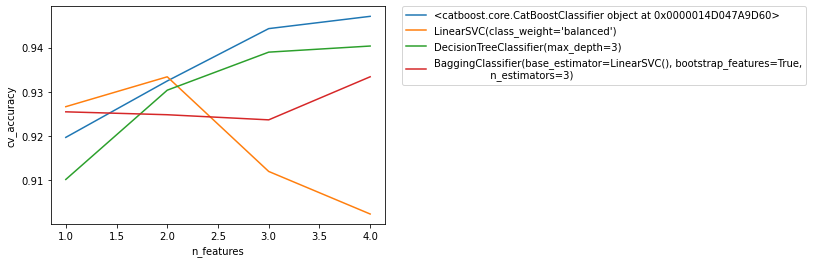

In [85]:
%matplotlib inline
# Show behavior of accuracy as number of features increases
sns.lineplot(data=eval_results_df, x='n_features', y='cv_accuracy', hue='model')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [86]:
print(eval_results_df.features.iloc[0])
print(eval_results_df.features.iloc[1])
print(eval_results_df.features.iloc[2])
print(eval_results_df.features.iloc[3])

occupancy_ratio
occupancy_ratio, spot_occupancy
occupancy_ratio, spot_occupancy, spot_intensity_sum
occupancy_ratio, on_off_ratio, spot_occupancy, spot_intensity_sum


### Examine results for a specific model and set of features

In [87]:
# Prepare input data
input_df = metrics_df[~metrics_df.score.isna()]  # Exclude unlabeled rows
input_df = input_df.sample(frac=1.0)  # Shuffle rows
X = input_df.drop(columns=['score'])
y = input_df.score.astype('i').values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [88]:
# Models to try
models_to_eval = [
    CatBoostClassifier(verbose=False)
]

features = ['spot_intensity_tic_norm', 'spot_occupancy', 'occupancy_vs_far_bg_ratio', 'intensity_vs_far_bg_ratio', 'intensity_vs_other_spots_ratio']

eval_results = []

for model in models_to_eval:
    model_name = str(model)
    print(model_name, features)
    # Evaluate using cross-validation
    X_subset = X[features].values
    fpos_idxs, fneg_idxs = get_mispredictions(model, X_subset, y)
    # Use a repeating cross-validator so that results are averaged over ~50 runs
    cv = RepeatedStratifiedKFold()
    cv_scores = cross_validate(model, X_subset, y, cv=cv, scoring=['accuracy','f1'])
    cv_accuracy = np.mean(cv_scores['test_accuracy'])
    cv_f1 = np.mean(cv_scores['test_f1'])
    
    # Evaluate using hold-out validation
    trained_subset_model = clone(model).fit(X_train[features].values, y_train)
    holdout_accuracy = trained_subset_model.score(X_test[features].values, y_test)
    holdout_f1 = f1_score(y_test, trained_subset_model.predict(X_test[features].values))
    
    eval_results.append({
        'model': model_name,
        'n_features': n_features,
        'features': ', '.join(features),
        'cv_accuracy': cv_accuracy,
        'cv_f1': cv_f1,
        'holdout_accuracy': holdout_accuracy,
        'holdout_f1': holdout_f1,
        'n_fpos': len(fpos_idxs),
        'n_fneg': len(fneg_idxs),
        # Uncomment to include the idxs of false positives/negatives to see which
        # inputs are repeatedly mispredicted regardless of the model
        # 'fpos_idxs': fpos_idxs,
        # 'fneg_idxs': fneg_idxs,
    })
        
eval_results_df = pd.DataFrame(eval_results)
eval_results_df

<catboost.core.CatBoostClassifier object at 0x0000014D02448F10> ['spot_intensity_tic_norm', 'spot_occupancy', 'occupancy_vs_far_bg_ratio', 'intensity_vs_far_bg_ratio', 'intensity_vs_other_spots_ratio']


,model,n_features,features,cv_accuracy,cv_f1,holdout_accuracy,holdout_f1,n_fpos,n_fneg
0,<catboost.core.CatBoostClassifier object at 0x...,4,"spot_intensity_tic_norm, spot_occupancy, occup...",0.941526,0.950679,0.942529,0.951456,12,12


## Train a new model

With features of your choice

In [17]:
model = CatBoostClassifier(verbose=False)
features =  ['spot_intensity_tic_norm', 'spot_occupancy', 'occupancy_vs_far_bg_ratio', 'intensity_vs_far_bg_ratio', 'intensity_vs_other_spots_ratio']

In [90]:
# Train the model on labeled data
train_df = metrics_df[~metrics_df.score.isna()]  # Exclude unlabeled rows
train_df = train_df.sample(frac=1.0)  # Shuffle rows
X_df = train_df.drop(columns=['score'])[features]
y = train_df.score.astype('i').values
trained_model = clone(model).fit(X_df.values, y)

# Make predictions for unlabeled data
unlabeled_df = metrics_df[metrics_df.score.isna()][features]
unlabeled_predictions_df = pd.DataFrame({
    'pred_val': trained_model.predict_proba(unlabeled_df.values)[:, 1]
}, index=unlabeled_df.index)

# Make cross-validated predictions for labeled data
labeled_predictions_df = pd.DataFrame({
    'pred_val': cross_val_predict(model, X_df.values, y, method='predict_proba')[:, 1]
}, index=X_df.index)

# Combine predictions
predictions_df = pd.concat([unlabeled_predictions_df, labeled_predictions_df])

### Assign labels to predictions

In [19]:
# Make combined DF
output_df = merged_df.join(metrics_df.drop(columns='score')).join(predictions_df)

# Add two-state and three-state classes
output_df['pred_twostate'] = np.where(output_df.pred_val < 0.5, 0, 1)
unsure_range = [0.2, 0.8] # Lowest & highest values to include in the "unsure" class
# This assigns 0 = negative, 1 = unsure, 2 = positive
output_df['pred_threestate'] = np.digitize(output_df.pred_val, unsure_range)

### Write predictions CSV files

In [20]:
csv_df = output_df.drop(columns=['image', 'tic_norm_image']) # Skip unwanted columns
csv_df.to_csv(p_predictions)

for dataset_id, results_df in csv_df.groupby('dataset_id'):
    output_path = p_eval / f'{dataset_id}_predictions.csv'
    results_df.to_csv(output_path)

### Write image files into false positives, false negatives, etc.

In [21]:
# Clean output directories
for output_path in [
    p_eval_fpos, p_eval_fneg, p_eval_tpos, p_eval_tneg, p_eval_upos, p_eval_uneg, 
    p_tri_pos, p_tri_unk, p_tri_neg
]:
    output_path.mkdir(parents=True, exist_ok=True)
    for f in output_path.glob('*.png'):
        f.unlink()  # Delete existing files

# Write images with two-state classification
for row in output_df.itertuples():
    mask = grids[row.dataset_id] == row.well
    
    # Figure out which directory to use
    if row.score == 0:
        twostate_path = [p_eval_tneg, p_eval_fpos][row.pred_twostate]
    elif row.score == 1:
        twostate_path = [p_eval_fneg, p_eval_tpos][row.pred_twostate]
    else:
        twostate_path = [p_eval_uneg, p_eval_upos][row.pred_twostate]
    
    save_image_with_mask(row.image, mask, twostate_path / row.filename, row.tic_norm_image)
    
# Write images with three-state classification
for row in output_df.itertuples():
    mask = grids[row.dataset_id] == row.well
    
    threestate_path = [p_tri_neg, p_tri_unk, p_tri_pos][row.pred_threestate]
    
    save_image_with_mask(row.image, mask, threestate_path / row.filename, row.tic_norm_image)

# Save trained model

Note: This JSON export only works for CatBoost. 
scikit-learn models don't have a standardized export format.

In [94]:
trained_model.save_model(p_model, format='json', pool=Pool(X_df.values, y))